#Import all the libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.utils import img_to_array

#Mount the drive

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


#Load the dataset

In [4]:
!gdown 1PbxpG74Qswfx1rhGQXFCVCaj_v05W2ZJ

Downloading...
From (original): https://drive.google.com/uc?id=1PbxpG74Qswfx1rhGQXFCVCaj_v05W2ZJ
From (redirected): https://drive.google.com/uc?id=1PbxpG74Qswfx1rhGQXFCVCaj_v05W2ZJ&confirm=t&uuid=03a3b647-8146-45c3-98b3-d7cc4ca16815
To: /content/Copy of Copy of devnagari digit.zip
100% 16.6M/16.6M [00:00<00:00, 55.2MB/s]


In [5]:
!unzip "/content/Copy of Copy of devnagari digit.zip" -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10299.png  
  inflating: /content/dataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10300.png  
  inflating: /content/dataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10301.png  
  inflating: /content/dataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10302.png  
  inflating: /content/dataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10303.png  
  inflating: /content/dataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10304.png  
  inflating: /content/dataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10306.png  
  inflating: /content/dataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10307.png  
  inflating: /content/dataset/DevanagariHandwrittenDigitDataset/Train/digit_7/104017.png  
  inflating: /content/dataset/DevanagariHandwrittenDigitDataset/Train/digit_7/104018.png  
  inflating: /content/dataset/DevanagariHandwri

In [6]:
# Setting the correct dataset path inside the Google Drive
dataset_path = '/content/dataset/DevanagariHandwrittenDigitDataset/Train'


# Load, pre-process and add noise to the dataset

In [7]:

# Loading the images
def load_images(dataset_path, image_size=(32, 32)):
    data = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                try:
                    img = Image.open(img_path).convert('L')  # grayscale
                    img = img.resize(image_size)
                    img = img_to_array(img) / 255.0  # Normalizing
                    data.append(img)
                except:
                    pass
    return np.array(data)

images = load_images(dataset_path)
images = images.reshape(-1, 32, 32, 1)  # reshaping for CNN input

# Adding noise (Gaussian)
def add_noise(data, noise_factor=0.5):
    noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy, 0., 1.)

noisy_images = add_noise(images)

# Splitting the dataset
x_train, x_test, x_train_noisy, x_test_noisy = train_test_split(
    images, noisy_images, test_size=0.2, random_state=42
)

# Build convolution denoising autocoder model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape)

    # Encoding
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoding
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,041 (652.50 KB)

 Trainable params: 167,041 (652.50 KB)

 Non-trainable params: 0 (0.00 B)

# Train the autoencoder

In [9]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.4162 - val_loss: 0.1824
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1800 - val_loss: 0.1678
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1676 - val_loss: 0.1608
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1614 - val_loss: 0.1571
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1585 - val_loss: 0.1547
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1551 - val_loss: 0.1529
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1532 - val_loss: 0.1507
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1522 - val_loss: 0.1502
Epoch 9/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1501 - val_loss: 0.1496
Epoch 10/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1494 - val_loss: 0.1474
Epoch 11/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1481 - val_loss: 0.1481
Epoch 12/20
107/107 ━━━━━━━━━━━━━━━━━━━━

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


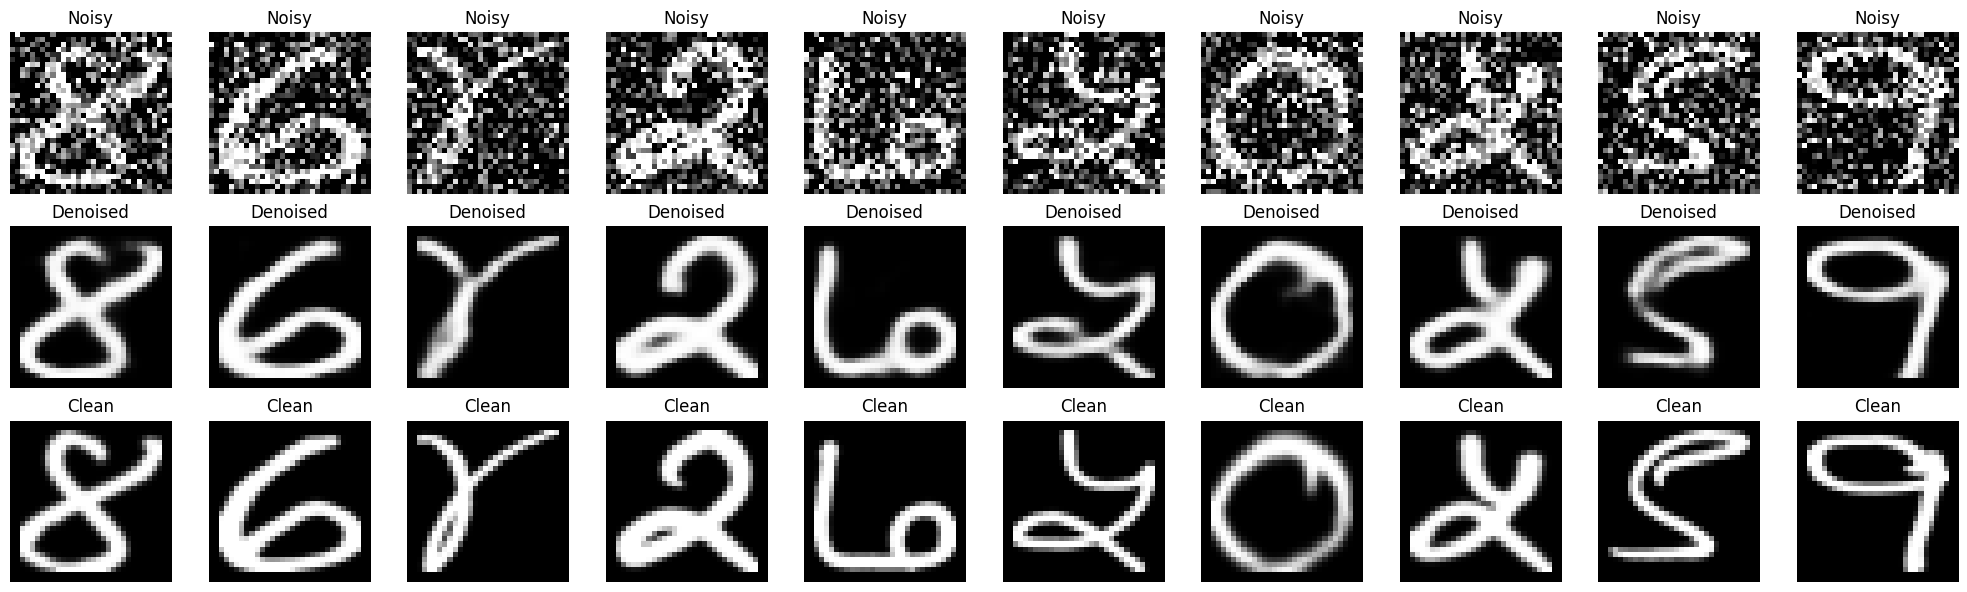

In [10]:
def plot_images(noisy, denoised, clean, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Noisy
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoising
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Cleaning
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean[i].reshape(32, 32), cmap='gray')
        plt.title("Clean")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predicting
denoised_images = autoencoder.predict(x_test_noisy)
plot_images(x_test_noisy, denoised_images, x_test)


In [11]:
def salt_pepper_noise(image, amount=0.01):
    noisy = image.copy()
    row, col, ch = image.shape[1], image.shape[2], image.shape[3]
    num_salt = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape[1:3]]
    noisy[:, coords[0], coords[1], :] = 1

    num_pepper = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape[1:3]]
    noisy[:, coords[0], coords[1], :] = 0
    return noisy


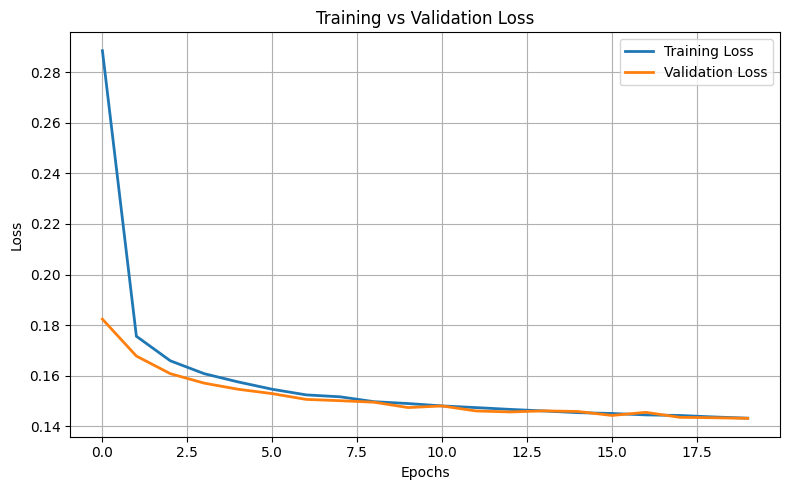

In [12]:
# 3.1 VISUALIZING TRAINING & VALIDATION LOSS

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Experiment

In [13]:

# Loading the images
def load_images(dataset_path, image_size=(32, 32)):
    data = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                try:
                    img = Image.open(img_path).convert('L')  # grayscale
                    img = img.resize(image_size)
                    img = img_to_array(img) / 255.0  # Normalizing
                    data.append(img)
                except:
                    pass
    return np.array(data)

images = load_images(dataset_path)
images = images.reshape(-1, 32, 32, 1)  # reshaping for CNN input

# Adding noise (Gaussian)
def add_noise(data, noise_factor=0.5):
    noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy, 0., 1.)

noisy_images = add_noise(images)

# Splitting the dataset
x_train, x_test, x_train_noisy, x_test_noisy = train_test_split(
    images, noisy_images, test_size=0.2, random_state=42
)

In [14]:

# Trying different noise levels
noisy_images_low = add_noise(images, noise_factor=0.3)
noisy_images_high = add_noise(images, noise_factor=0.7)

# Splitting again for new noise factors
x_train_l, x_test_l, x_train_noisy_l, x_test_noisy_l = train_test_split(images, noisy_images_low, test_size=0.2, random_state=42)
x_train_h, x_test_h, x_train_noisy_h, x_test_noisy_h = train_test_split(images, noisy_images_high, test_size=0.2, random_state=42)


In [15]:

# Deeper Autoencoder
def build_deeper_autoencoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Extra layer
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

deeper_autoencoder = build_deeper_autoencoder()
deeper_autoencoder.fit(x_train_noisy, x_train, epochs=3, batch_size=128, validation_split=0.1)


Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.5088 - val_loss: 0.2690
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2377 - val_loss: 0.2008
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1923 - val_loss: 0.1810


In [17]:

# Shallower Autoencoder
def build_shallower_autoencoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

shallower_autoencoder = build_shallower_autoencoder()
shallower_autoencoder.fit(x_train_noisy, x_train, epochs=3, batch_size=128, validation_split=0.1)


Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.4366 - val_loss: 0.1806
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1765 - val_loss: 0.1702
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1678 - val_loss: 0.1658


In [18]:

# Train with low and high noise levels
model_low_noise = build_autoencoder()
model_low_noise.fit(x_train_noisy_l, x_train_l, epochs=3, batch_size=128, validation_split=0.1)

model_high_noise = build_autoencoder()
model_high_noise.fit(x_train_noisy_h, x_train_h, epochs=3, batch_size=128, validation_split=0.1)


Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.3768 - val_loss: 0.1568
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1511 - val_loss: 0.1423
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1397 - val_loss: 0.1375
Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.4410 - val_loss: 0.2265
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2277 - val_loss: 0.2103
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2073 - val_loss: 0.2012


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


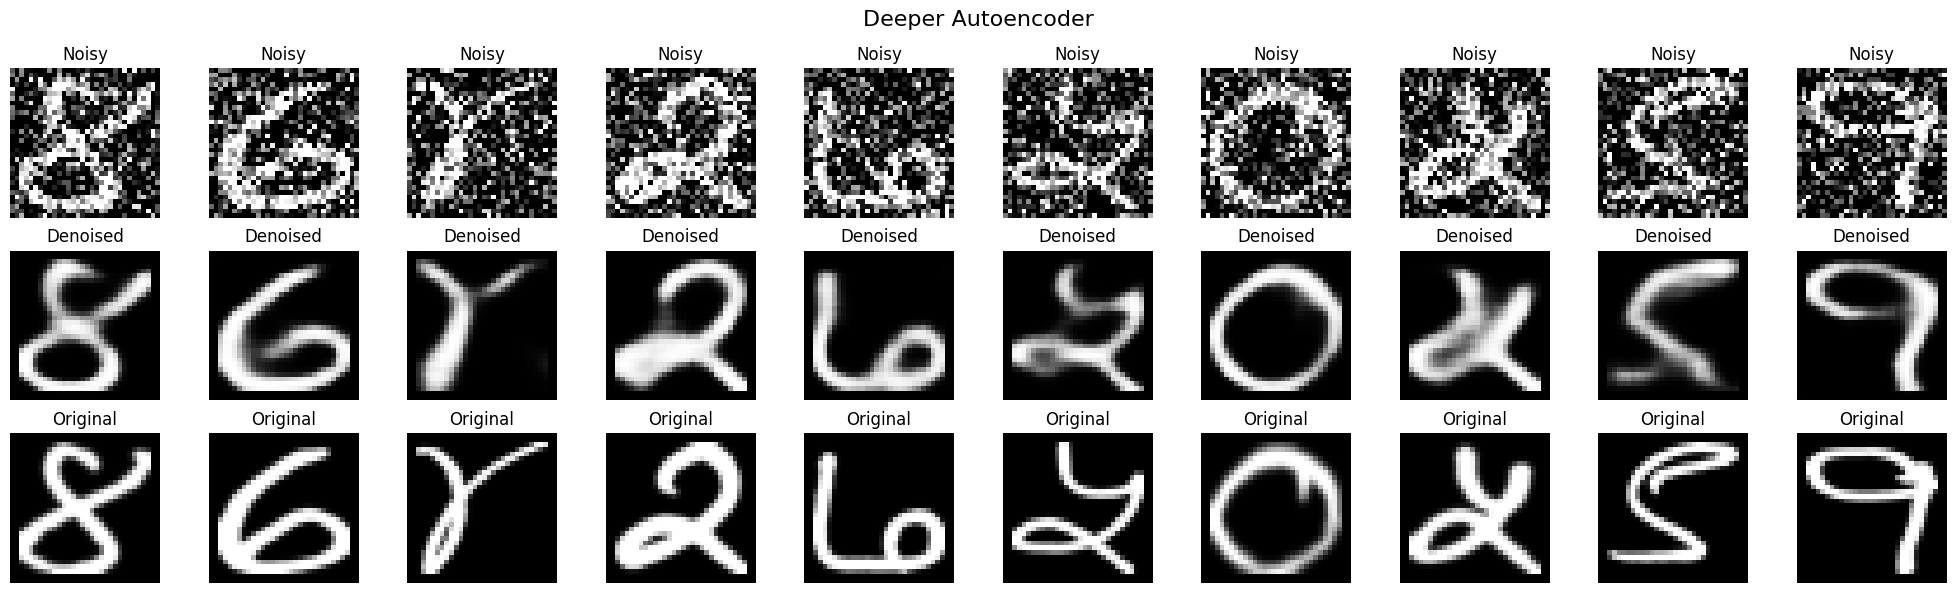

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


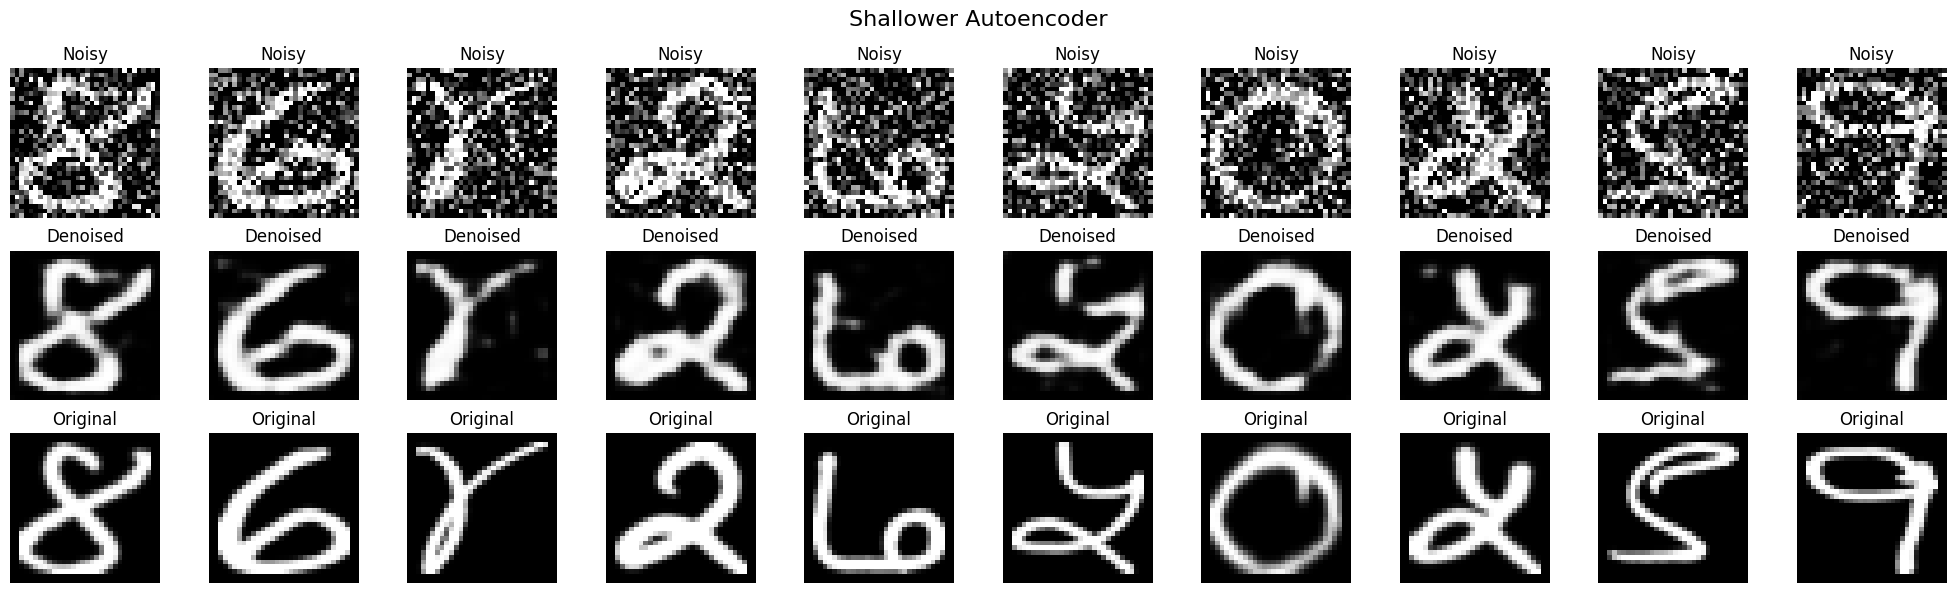

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


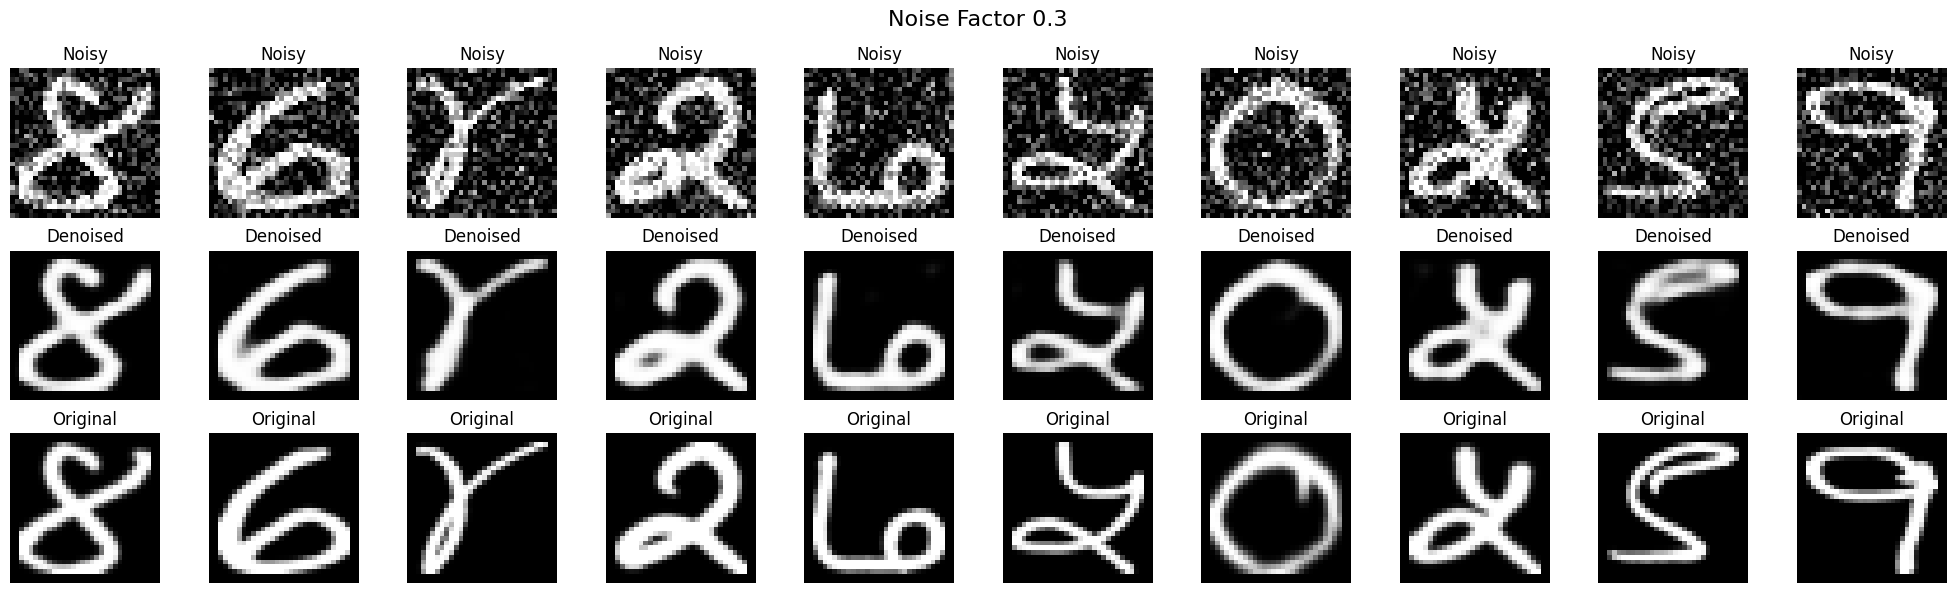

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


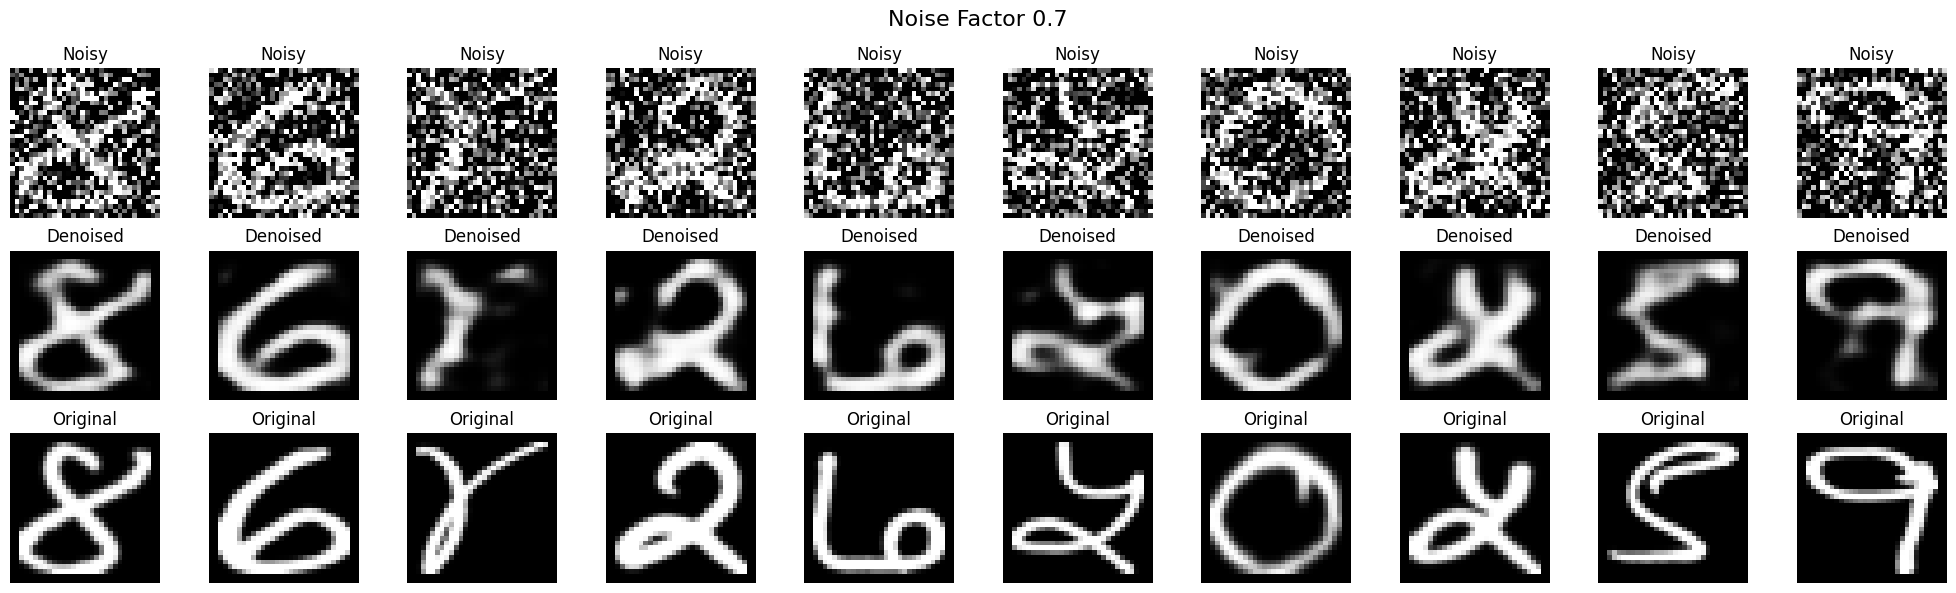

In [19]:

import matplotlib.pyplot as plt

def visualize_results(model, x_test_noisy, x_test, title):
    decoded_imgs = model.predict(x_test_noisy[:10])
    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original + noise
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(32, 32), cmap="gray")
        plt.title("Noisy")
        plt.axis("off")

        # Display reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(32, 32), cmap="gray")
        plt.title("Denoised")
        plt.axis("off")

        # Display original
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(x_test[i].reshape(32, 32), cmap="gray")
        plt.title("Original")
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize deeper model
visualize_results(deeper_autoencoder, x_test_noisy, x_test, "Deeper Autoencoder")

# Visualize shallower model
visualize_results(shallower_autoencoder, x_test_noisy, x_test, "Shallower Autoencoder")

# Visualize low noise
visualize_results(model_low_noise, x_test_noisy_l, x_test_l, "Noise Factor 0.3")

# Visualize high noise
visualize_results(model_high_noise, x_test_noisy_h, x_test_h, "Noise Factor 0.7")


#Observations
Deeper Model: Cleaned the noisy images better and gave more accurate results, but it took longer to train.

Shallower Model: Trained quickly but didn’t clean the images as well.

Noise Factor (0.3): Images were easy to clean since they had very little noise.

Noise Factor (0.7): Too much noise made it hard for the model to recover the original image clearly.

Conclusion: Using more layers helps the model learn better, but it also needs more time. A medium noise level (around 0.5) gives the best balance between performance and difficulty.